# Calculating SGS Terms
$$\tau_{ij} = \overline{u_iu}_j - \overline{u}_i \overline{u}_j$$ 
$$  \sigma_{i} = \overline{u_i\omega} - \overline{u}_i\overline{\omega}$$
$$\Pi_{\omega} = \nabla \times \Pi_{UV} = \nabla \times \nabla \cdot \tau$$
$$\Pi_{\omega} = \nabla \cdot \sigma $$

float64 float64 float64 float64


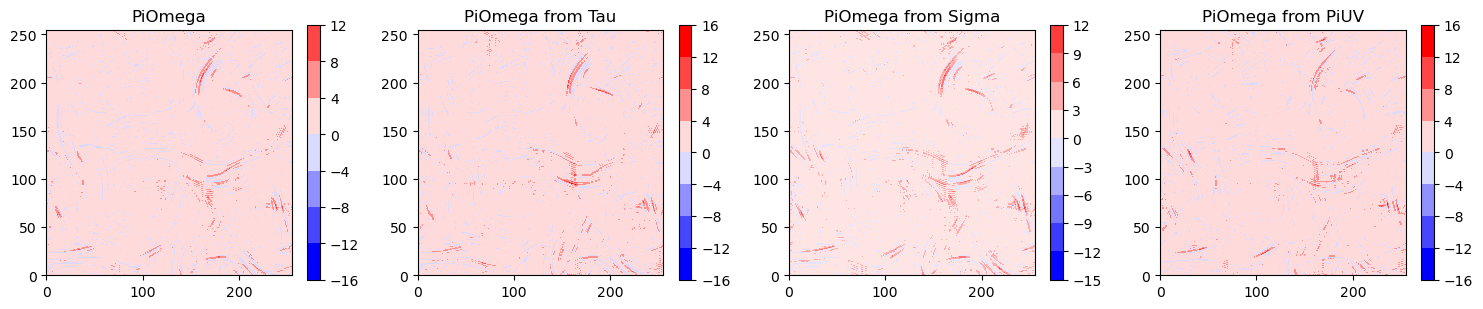

MSE between PiOmega and PiOmega from Tau: 4.092185332701559
MSE between PiOmega and PiOmega from Sigma: 0.09540178824032694
MSE between PiOmega and PiOmega from PiUV: 5.760292444958681
Correlation coefficient between PiOmega and PiOmega from Tau: 0.17073093953035035
Correlation coefficient between PiOmega and PiOmega from Sigma: 0.9789323483563367
Correlation coefficient between PiOmega and PiOmega from PiUV: -0.21141024760790317


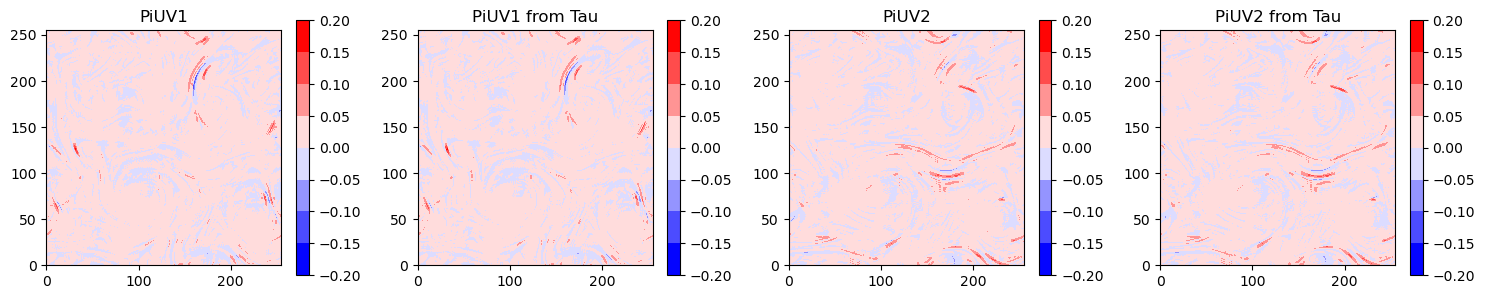

MSE between PiUV1 and PiUV1 from Tau: 4.8995149935597125e-06
MSE between PiUV2 and PiUV2 from Tau: 6.179093914852464e-06
Correlation coefficient between PiUV1 and PiUV1 from Tau: 0.9905763465607382
Correlation coefficient between PiUV2 and PiUV2 from Tau: 0.9904402158758847


In [2]:
# Import necessary libraries and modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from scipy.io import loadmat

# Importing custom modules 
from py2d.filter import filter2D_2DFHIT
from py2d.SGSterms import Tau, Sigma, PiOmega, PiUV
from py2d.convert import Tau2PiOmega_2DFHIT, Sigma2PiOmega, Tau2PiUV_2DFHIT, PiUV2PiOmega
from py2d.initialize import initialize_wavenumbers_2DFHIT

# Assuming Omega_DNS is provided and is 2D_matrix
# Assuming Kx and Ky are provided

# Define parameters 
nx = 1024
filename = '../data/ICs/NX' + str(nx) + '/1.mat'
Lx = 2 * np.pi
N_LES = 256
Delta = 2*Lx/N_LES

filter = 'gaussian'
coarseGrain = 'spectral'

# Load the data from the file
data = loadmat(filename)
# Extract the Omega data from the file
Omega_DNS = data['Omega']

# Initialize wavenumbers
Kx, Ky, Ksq, _, _ = initialize_wavenumbers_2DFHIT(nx, nx, Lx, Lx, INDEXING='ij')

if coarseGrain == 'spectral':
    Kx_coarse, Ky_coarse, Ksq_coarse, _, _ = initialize_wavenumbers_2DFHIT(N_LES, N_LES, Lx, Lx, INDEXING='ij')
elif coarseGrain == None:
    Kx_coarse, Ky_coarse, Ksq_coarse, _, _ = initialize_wavenumbers_2DFHIT(nx, nx, Lx, Lx, INDEXING='ij')

# Calculate the Tau values
Tau11, Tau12, Tau22 = Tau(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=N_LES)

# Calculate the PiUV values
PiUV1, PiUV2 = PiUV(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=N_LES)

# Calculate the Sigma values
Sigma1, Sigma2 = Sigma(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=N_LES)

# Calculate the PiOmega values
PiOmega = PiOmega(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=N_LES)

# Calculate PiUV from Tau
PiUV1_from_Tau, PiUV2_from_Tau = Tau2PiUV_2DFHIT(Tau11=Tau11, Tau12=Tau12, Tau22=Tau22, Kx=Kx_coarse, Ky=Ky_coarse, spectral=False)

# Calculate PiOmega from Tau
PiOmega_from_Tau = Tau2PiOmega_2DFHIT(Tau11=Tau11, Tau12=Tau12, Tau22=Tau22, Kx=Kx_coarse, Ky=Ky_coarse, spectral=False)

# Calculate PiOmega from Sigma
PiOmega_from_Sigma = Sigma2PiOmega(Sigma1=Sigma1, Sigma2=Sigma2, Kx=Kx_coarse, Ky=Ky_coarse, spectral=False)

# Calculate PiOmega from PiUV
PiOmega_from_PiUV = PiUV2PiOmega(PiUV1=PiUV1, PiUV2=PiUV2, Kx=Kx_coarse, Ky=Ky_coarse, spectral=False)

# Find the maximum absolute value across all datasets for symmetric colorbar
vmax = np.max(np.abs([PiOmega, PiOmega_from_Tau, PiOmega_from_Sigma, PiOmega_from_PiUV]))

# Plot contours of all computed values
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
cmaps = ['PiOmega', 'PiOmega from Tau', 'PiOmega from Sigma', 'PiOmega from PiUV']
data = [PiOmega, PiOmega_from_Tau, PiOmega_from_Sigma, PiOmega_from_PiUV]

# Loop through all data to plot
for ax, cmap, dat in zip(axs.flat, cmaps, data):
    contour = ax.contourf(dat, cmap='bwr', vmin=-vmax, vmax=vmax)
    ax.set_title(cmap)
    ax.set_aspect('equal')
    fig.colorbar(contour, ax=ax)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Calculate mean squared errors for comparison
mse_tau = mean_squared_error(PiOmega, PiOmega_from_Tau)
mse_sigma = mean_squared_error(PiOmega, PiOmega_from_Sigma)
mse_PiUV = mean_squared_error(PiOmega, PiOmega_from_PiUV)

# Display the computed MSE values
print(f"MSE between PiOmega and PiOmega from Tau: {mse_tau}")
print(f"MSE between PiOmega and PiOmega from Sigma: {mse_sigma}")
print(f"MSE between PiOmega and PiOmega from PiUV: {mse_PiUV}")

# Calculate correlation coefficients for comparison
corr_tau, _ = pearsonr(PiOmega.flatten(), PiOmega_from_Tau.flatten())
corr_sigma, _ = pearsonr(PiOmega.flatten(), PiOmega_from_Sigma.flatten())
corr_PiUV, _ = pearsonr(PiOmega.flatten(), PiOmega_from_PiUV.flatten())

# Display the computed correlation coefficients
print(f"Correlation coefficient between PiOmega and PiOmega from Tau: {corr_tau}")
print(f"Correlation coefficient between PiOmega and PiOmega from Sigma: {corr_sigma}")
print(f"Correlation coefficient between PiOmega and PiOmega from PiUV: {corr_PiUV}")

# Find the maximum absolute value across all datasets for symmetric colorbar
vmax = np.max(np.abs([PiUV1, PiUV1_from_Tau, PiUV2, PiUV2_from_Tau]))

# Plot contours of all computed PiUV values
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
cmaps = ['PiUV1', 'PiUV1 from Tau', 'PiUV2', 'PiUV2 from Tau']
data = [PiUV1, PiUV1_from_Tau, PiUV2, PiUV2_from_Tau]

# Loop through all data to plot
for ax, cmap, dat in zip(axs.flat, cmaps, data):
    contour = ax.contourf(dat, cmap='bwr', vmin=-vmax, vmax=vmax)
    ax.set_title(cmap)
    ax.set_aspect('equal')
    fig.colorbar(contour, ax=ax)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Calculate mean squared errors for comparison
mse_PiUV1 = mean_squared_error(PiUV1, PiUV1_from_Tau)
mse_PiUV2 = mean_squared_error(PiUV2, PiUV2_from_Tau)

# Display the computed MSE values
print(f"MSE between PiUV1 and PiUV1 from Tau: {mse_PiUV1}")
print(f"MSE between PiUV2 and PiUV2 from Tau: {mse_PiUV2}")

# Calculate correlation coefficients for comparison
corr_PiUV1, _ = pearsonr(PiUV1.flatten(), PiUV1_from_Tau.flatten())
corr_PiUV2, _ = pearsonr(PiUV2.flatten(), PiUV2_from_Tau.flatten())

# Display the computed correlation coefficients
print(f"Correlation coefficient between PiUV1 and PiUV1 from Tau: {corr_PiUV1}")
print(f"Correlation coefficient between PiUV2 and PiUV2 from Tau: {corr_PiUV2}")

